### Library 

In [2]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats

path_main_folder = '/home/antorosi/Documents/AutoEncoder'

sys.path.append(path_main_folder)

from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE
from conso.load_shape_data import *  
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error

### Load and shape data 

In [3]:
# Load raw data
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

In [4]:
# Load Holiday day information
holiday_days_csv = os.path.join(path_data, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

In [5]:
# Unifomization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

In [6]:
# Change ganularity ?
name_granu = '30m'
data_conso_df = change_granularity(data_conso_df, granularity="30min")

In [7]:
# Get x_conso dataframe for autoencoder purpose
x_conso = get_x_conso_autoencoder(data_conso_df, dict_colnames_conso)

### Build dataset 

In [8]:
# Split train and test
#date_test_start = datetime.date(2014,1,1)
#date_test_end = x_conso.ds.max()
#dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)

dict_xconso = {'train': x_conso}

In [9]:
# Normalize x_conso
type_scaler = 'standard'
dict_xconso = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [10]:
name_type_cond = 'm-wd'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c-temp'
type_x = ['conso', 'temperature']
type_cond = ['month', 'weekday']

In [11]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond)

In [12]:
dataset['train']['x'][0].shape

(1830, 96)

### Build model

In [13]:
path_out = os.path.join(path_main_folder, 'out')

In [14]:
name_model = 'cvae_conso_e48-24-12_d12-24-48_z2_gran-{}_x-{}_cond-{}'.format(name_granu, name_type_x, name_type_cond)

In [15]:
name_model

'cvae_conso_e48-24-12_d12-24-48_z2_gran-30m_x-c-temp_cond-m-wd'

In [232]:
# Parameters
cond_dim = dataset['train']['x'][1].shape[1]
e_dims=[48,24,12]
d_dims=[12,24,48]
z_dim=4
beta = 0.4

In [233]:
model = CVAE(cond_dim=cond_dim, 
             e_dims=e_dims, 
             d_dims=d_dims, 
             z_dim=z_dim, 
             beta=beta,
             name=name_model, 
             output=path_out)

complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 96)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 14)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 6908        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0           encoder[1][0]              

### Trainning model 



--- START TRAINING ---

Epoch 1/200
1830/1830 [==============================] - 0s 208us/step - loss: 41.0945 - kl_loss: 10.4739 - recon_loss: 36.9049
Epoch 2/200
1830/1830 [==============================] - 0s 69us/step - loss: 11.0715 - kl_loss: 7.7600 - recon_loss: 7.9675
Epoch 3/200
1830/1830 [==============================] - 0s 72us/step - loss: 8.3247 - kl_loss: 6.8728 - recon_loss: 5.5755
Epoch 4/200
1830/1830 [==============================] - 0s 71us/step - loss: 7.2424 - kl_loss: 6.6502 - recon_loss: 4.5824
Epoch 5/200
1830/1830 [==============================] - 0s 72us/step - loss: 6.5877 - kl_loss: 6.4664 - recon_loss: 4.0012
Epoch 6/200
1830/1830 [==============================] - 0s 72us/step - loss: 6.3591 - kl_loss: 6.3309 - recon_loss: 3.8267
Epoch 7/200
1830/1830 [==============================] - 0s 70us/step - loss: 6.1697 - kl_loss: 6.2958 - recon_loss: 3.6514
Epoch 8/200
1830/1830 [==============================] - 0s 71us/step - loss: 6.0453 - kl_loss: 6.295

1830/1830 [==============================] - 0s 69us/step - loss: 3.4601 - kl_loss: 4.6728 - recon_loss: 1.5910
Epoch 67/200
1830/1830 [==============================] - 0s 69us/step - loss: 3.5046 - kl_loss: 4.6574 - recon_loss: 1.6417
Epoch 68/200
1830/1830 [==============================] - 0s 71us/step - loss: 3.4629 - kl_loss: 4.6520 - recon_loss: 1.6021
Epoch 69/200
1830/1830 [==============================] - 0s 74us/step - loss: 3.4565 - kl_loss: 4.6387 - recon_loss: 1.6010
Epoch 70/200
1830/1830 [==============================] - 0s 74us/step - loss: 3.4038 - kl_loss: 4.5360 - recon_loss: 1.5894
Epoch 71/200
1830/1830 [==============================] - 0s 69us/step - loss: 3.4268 - kl_loss: 4.5452 - recon_loss: 1.6087
Epoch 72/200
1830/1830 [==============================] - 0s 71us/step - loss: 3.4167 - kl_loss: 4.4829 - recon_loss: 1.6236
Epoch 73/200
1830/1830 [==============================] - 0s 73us/step - loss: 3.4207 - kl_loss: 4.5098 - recon_loss: 1.6168
Epoch 74/200


1830/1830 [==============================] - 0s 66us/step - loss: 3.0098 - kl_loss: 3.8978 - recon_loss: 1.4506
Epoch 132/200
1830/1830 [==============================] - 0s 69us/step - loss: 2.9835 - kl_loss: 3.8602 - recon_loss: 1.4394
Epoch 133/200
1830/1830 [==============================] - 0s 69us/step - loss: 2.9526 - kl_loss: 3.8754 - recon_loss: 1.4025
Epoch 134/200
1830/1830 [==============================] - 0s 72us/step - loss: 2.9805 - kl_loss: 3.8559 - recon_loss: 1.4381
Epoch 135/200
1830/1830 [==============================] - 0s 70us/step - loss: 2.9810 - kl_loss: 3.8008 - recon_loss: 1.4607
Epoch 136/200
1830/1830 [==============================] - 0s 76us/step - loss: 2.9694 - kl_loss: 3.9083 - recon_loss: 1.4061
Epoch 137/200
1830/1830 [==============================] - 0s 74us/step - loss: 2.9594 - kl_loss: 3.8393 - recon_loss: 1.4237
Epoch 138/200
1830/1830 [==============================] - 0s 70us/step - loss: 2.9592 - kl_loss: 3.7990 - recon_loss: 1.4396
Epoch 

1830/1830 [==============================] - 0s 72us/step - loss: 2.8287 - kl_loss: 3.6831 - recon_loss: 1.3555
Epoch 197/200
1830/1830 [==============================] - 0s 70us/step - loss: 2.8067 - kl_loss: 3.7216 - recon_loss: 1.3181
Epoch 198/200
1830/1830 [==============================] - 0s 69us/step - loss: 2.8363 - kl_loss: 3.7142 - recon_loss: 1.3506
Epoch 199/200
1830/1830 [==============================] - 0s 74us/step - loss: 2.8344 - kl_loss: 3.7030 - recon_loss: 1.3532
Epoch 200/200
1830/1830 [==============================] - 0s 75us/step - loss: 2.8625 - kl_loss: 3.7343 - recon_loss: 1.3688


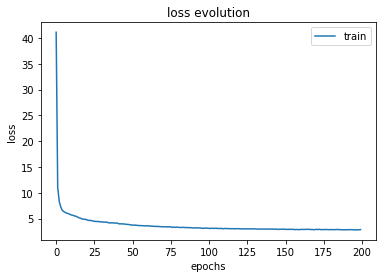

In [234]:
model.main_train(dataset, training_epochs=200, batch_size=20, verbose=False)

### Loading model 

In [235]:
model.load_model(os.path.join(path_out, name_model, 'models'))

### Analysis of the latent space

In [236]:
name_set_plot = 'train'
version = ''

In [251]:
x_encoded = model.encoder.predict(dataset[name_set_plot]['x'])[0]

In [252]:
x_encoded = x_encoded[:,[0,3]]

In [253]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

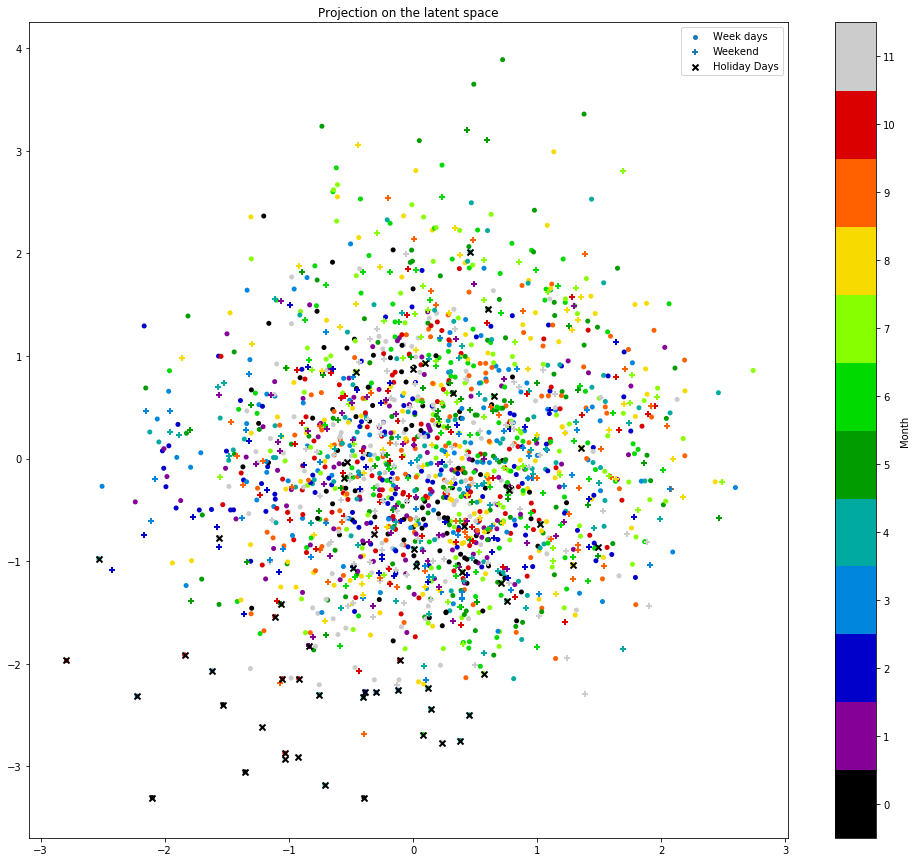

In [254]:
name_plot = 'z2_beta-{}_train-{}_set-{}_cond-{}{}'.format(str(beta), name_train, name_set_plot,str(name_type_cond),version)
plot_latent_space_projection(x_proj=x_encoded, calendar_info=calendar_info,
                             path_folder_out=os.path.join(path_out,name_model,'results'), name=name_plot, 
                             pyplot=True, plotly = False)

In [255]:
temp = get_cond_autoencoder(dataset['train']['ds'], type_cond=['temp'], data_conso_df=data_conso_df)
temp = temp.flatten()

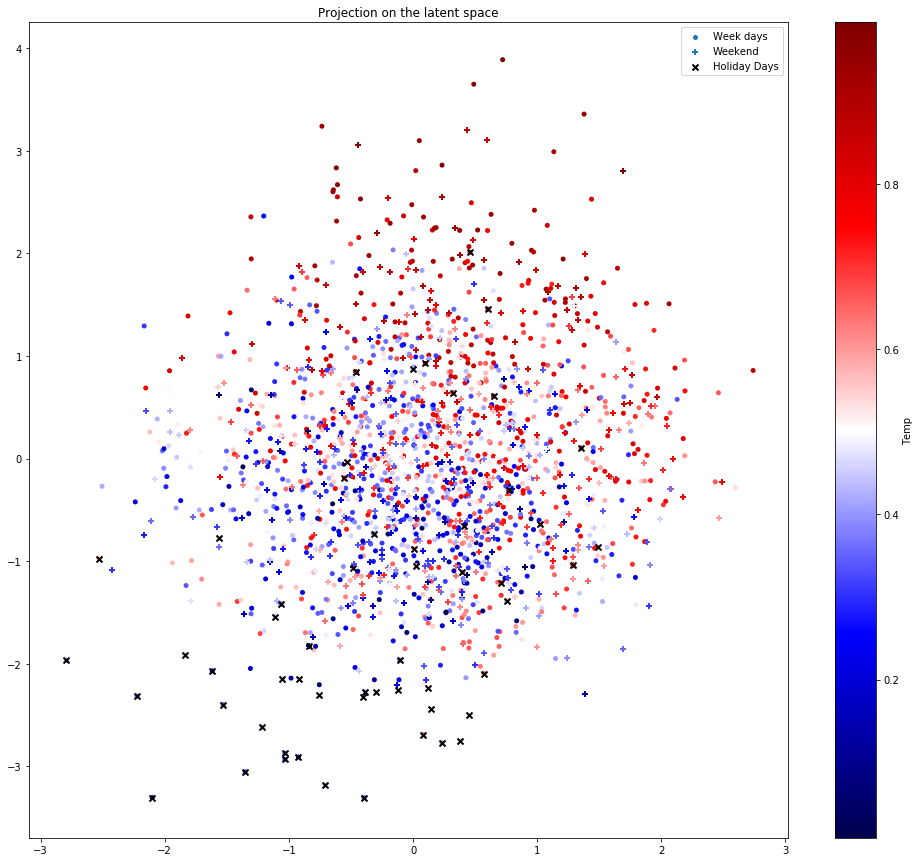

In [256]:
name_plot = 'temp_z2_beta-{}_train-{}_set-{}_cond-{}{}'.format(str(beta), name_train, name_set_plot,str(name_type_cond),version)
pyplot_latent_space_projection_temp(x_encoded, calendar_info, temp,os.path.join(path_out,name_model,'results'), name_plot)

### Analyse of the reconstruction error

In [257]:
[x, cond] = dataset['train']['x']
x_hat = model.cvae.predict(x=[x, cond])

In [258]:
res_mat = (x - x_hat)
res = res_mat.mean(axis=1)

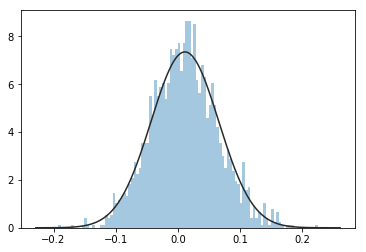

In [259]:
sn.distplot(res, kde=False, fit=stats.norm, bins=100)

In [260]:
res_conso_mat = res_mat[:,:48]
res_temp_mat = res_mat[:,48:]

In [261]:
res_conso = res_conso_mat.mean(axis=1)
res_temp = res_temp_mat.mean(axis=1)

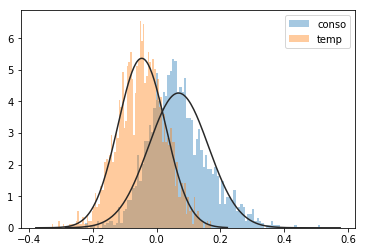

In [262]:
sn.distplot(res_conso, kde=False, fit=stats.norm, bins=100, label='conso')
sn.distplot(res_temp, kde=False, fit=stats.norm, bins=100, label='temp')
plt.legend()

In [263]:
results = dict()
results['me'] = {'all': res, 'temp': res_temp, 'conso': res_conso}

In [264]:
results['mae'] = {
    'all': np.apply_along_axis(lambda x: np.abs(x).mean(),1, res_mat),
    'conso': np.apply_along_axis(lambda x: np.abs(x).mean(),1, res_conso_mat),
    'temp': np.apply_along_axis(lambda x: np.abs(x).mean(),1, res_temp_mat)
}

In [265]:
results['z_score'] = {}
results['a_score'] = {}

for key, me in results['me'].items():
    z_score = stats.zscore(me)
    a_score = 1-2 * stats.norm.cdf(-np.abs(z_score))
    
    results['z_score'][key] = z_score
    results['a_score'][key] = a_score

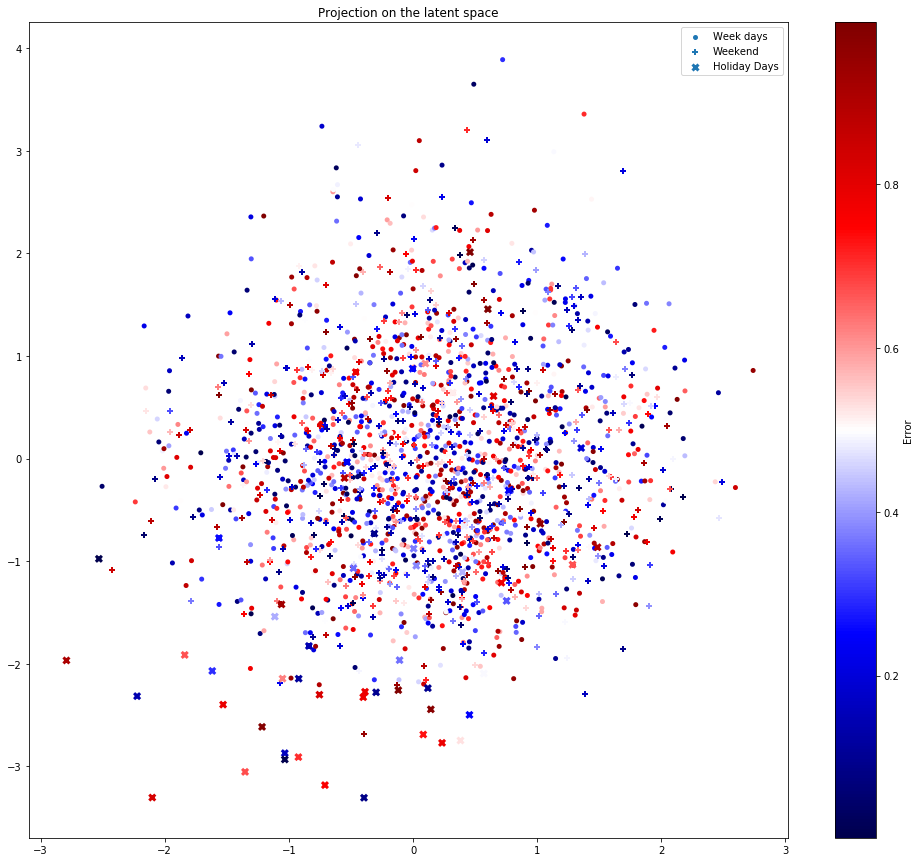

In [266]:
type_error = 'a_score'
type_data = 'conso'

name_plot = '{}-{}_z2_beta-{}_train-{}_set-{}_cond-{}{}'.format(type_error,type_data,str(beta), name_train, name_set_plot,str(name_type_cond),version)
path_plot = os.path.join(path_out,name_model,'results')

error = results[type_error][type_data]
pyplot_latent_space_projection_error(x_encoded, calendar_info, error, color='seismic', path_folder_out=path_plot, name=name_plot)

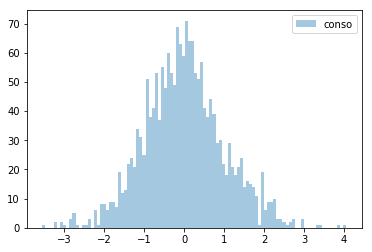

In [227]:
sn.distplot(results['z_score']['conso'], kde=False, bins=100, label='conso')
plt.legend()

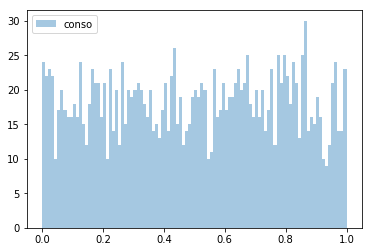

In [146]:
sn.distplot(results['a_score']['conso'], kde=False, bins=100, label='conso')
plt.legend()

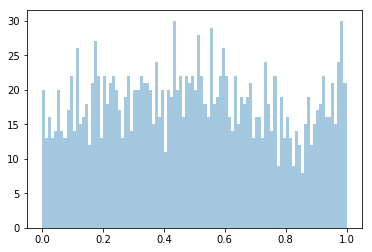

In [228]:
sn.distplot(stats.norm.cdf(results['z_score']['conso']), kde=False, bins=100, label='conso')

In [168]:
indice = 450

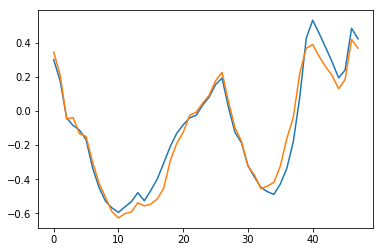

In [169]:
plt.plot(x[indice,:48])
plt.plot(x_hat[indice,:48])

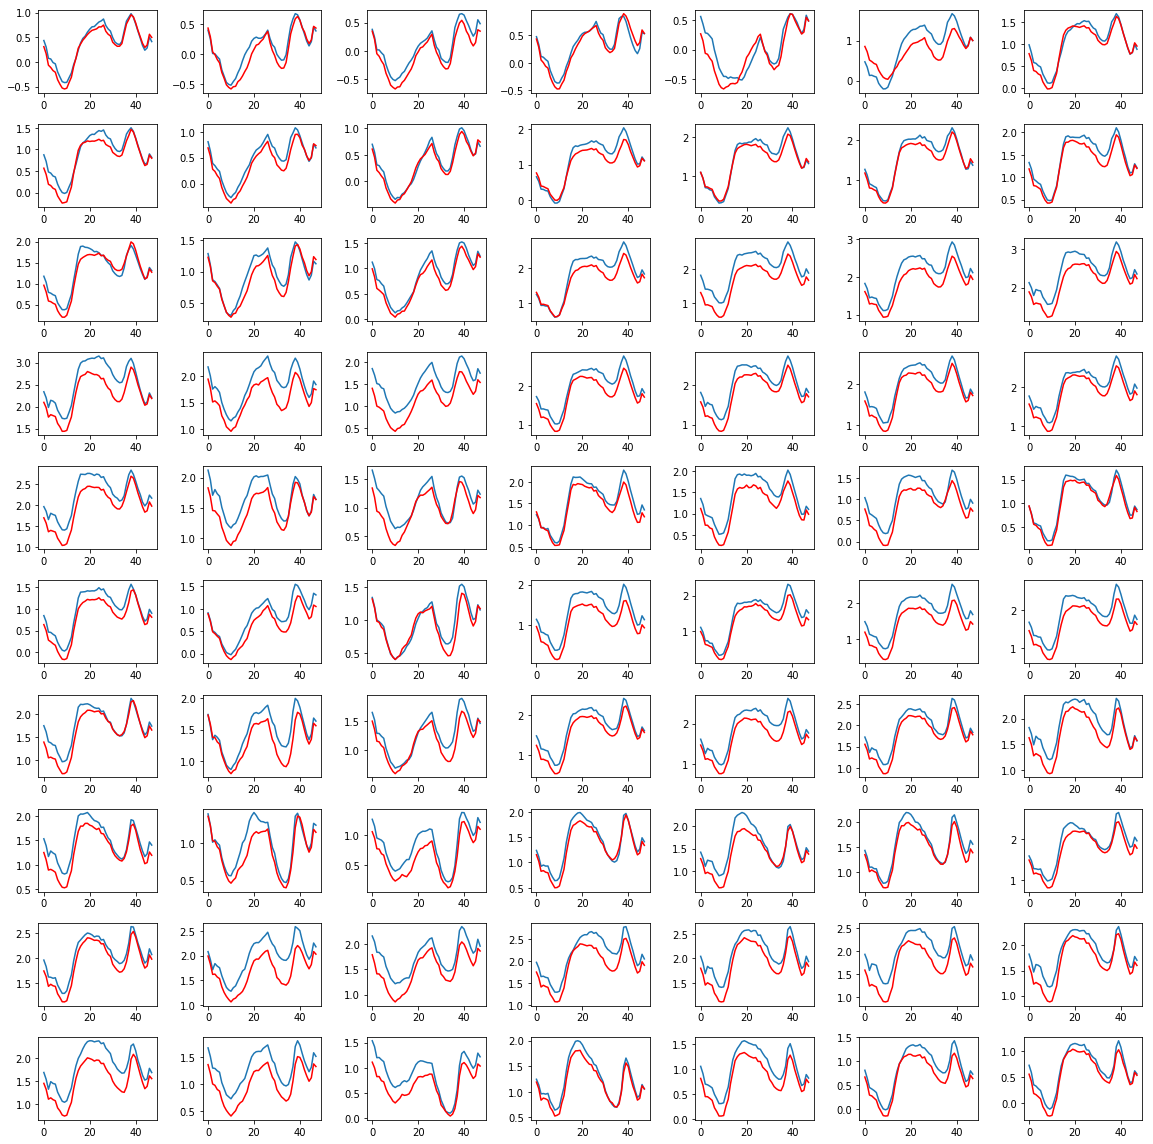

In [268]:
fig, axes = plt.subplots(10,7, figsize=(16,16))

ind = 0

for ax_row in axes:
    for ax in ax_row:
        # create a twin of the axis that shares the x-axis
        # plot some data on each axis.
        ax.plot(x[ind,:48])
        ax.plot(x_hat[ind,:48],'-r')
        
        ind+=1

plt.tight_layout()
plt.show()